# Hotel Reviews: Data Prep & EDA

## Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict

import langid
import seaborn as sns

cmaps = OrderedDict()

import warnings
warnings.filterwarnings('ignore')

## Import Data

In [2]:
df = pd.read_csv('data/7282_1.csv')
df.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


In [3]:
df.shape

(35912, 19)

## Missing Values and Drop Columns

The main two columns I'm interested in is reviews.rating and reviews.text. This is the star rating and text of the review. 

In [4]:
df.isnull().sum()

address                     0
categories                  0
city                        0
country                     0
latitude                   86
longitude                  86
name                        0
postalCode                 55
province                    0
reviews.date              259
reviews.dateAdded           0
reviews.doRecommend     35912
reviews.id              35912
reviews.rating            862
reviews.text               22
reviews.title            1622
reviews.userCity        19649
reviews.username           43
reviews.userProvince    18394
dtype: int64

In [5]:
# drop columns where all values are missing and unwanted columns

df.drop(['reviews.doRecommend', 'reviews.id', 'address', 'categories', 'country','postalCode', 'reviews.username', 
         'reviews.title', 'reviews.id', 'reviews.dateAdded'],
        axis=1, inplace=True)

In [6]:
# drop any rows where rating is missing

df.dropna(subset=['reviews.rating', 'reviews.text'], inplace=True)

In [7]:
df.isnull().sum()

city                        0
latitude                   76
longitude                  76
name                        0
province                    0
reviews.date              257
reviews.rating              0
reviews.text                0
reviews.userCity        18893
reviews.userProvince    17622
dtype: int64

## Rename Columns

In [8]:
# rename columns
df.rename(columns={'city': 'hotel_city', 'province':'hotel_state', 'reviews.date': 'date', 
                   'reviews.rating': 'rating', 'reviews.text': 'text', 'reviews.userCity': 'user_city', 
                  'reviews.userProvince': 'user_state'}, inplace=True)

In [9]:
df.head(2)

,hotel_city,latitude,longitude,name,hotel_state,date,rating,text,user_city,user_state
0,Mableton,45.421611,12.376187,Hotel Russo Palace,GA,2013-09-22T00:00:00Z,4.0,Pleasant 10 min walk along the sea front to th...,NaN,NaN
1,Mableton,45.421611,12.376187,Hotel Russo Palace,GA,2015-04-03T00:00:00Z,5.0,Really lovely hotel. Stayed on the very top fl...,NaN,NaN


## Column Types

In [10]:
df.dtypes

hotel_city      object
latitude       float64
longitude      float64
name            object
hotel_state     object
date            object
rating         float64
text            object
user_city       object
user_state      object
dtype: object

In [11]:
# change date column to datetime
df['date'] = pd.to_datetime(df['date'])

## Duplicated Rows

In [12]:
df.duplicated().sum()

89

In [13]:
# drop duplicated rows
df.drop_duplicates(inplace=True)

## Duplicated Text

Check for duplicated reviews, if the same review was submitted twice but at different times, then it is dropped. 

In [14]:
df.duplicated(subset=['text']).sum()

1309

In [15]:
df.drop_duplicates(subset=['text'], inplace=True)

## Outliers

What range of score does the ratings have?

In [16]:
# unique ratings
df.rating.unique()

array([ 4. ,  5. ,  3. ,  1. ,  2. ,  0. ,  4.1,  4.9,  4.8,  3.4,  2.4,
        3.1,  3.3,  9.6, 10. ,  8.3,  8.8,  9.2,  7.5,  7.9,  7.1,  3.8,
        5.8,  6.7,  6.3,  4.2,  4.5,  3.9,  1.3,  4.3,  4.7,  2.8,  4.4,
        1.5,  4.6,  3.7,  5.4,  2.5,  6. ,  2.9,  7. ,  9.5])

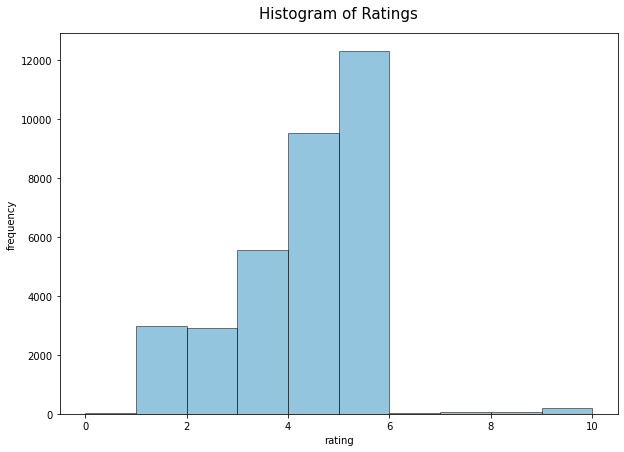

In [17]:
num_bins = 10

fig, ax = plt.subplots(figsize = (10,7))

n, bins, patches = ax.hist(df['rating'], num_bins, facecolor='#2b8cbe', alpha=0.5, edgecolor='#000000', linewidth=1)

ax.set_title('Histogram of Ratings', fontsize = 15, pad=15)
ax.set_xlabel('rating')
ax.set_ylabel('frequency')

plt.show()

The histogram has very little values over 5. I will remove these and consider them outliers and keep a 1-5 rating. 

In [18]:
# filter out values over 5

df = df.loc[(df['rating'] > 0) & (df['rating'] <= 5.0)]

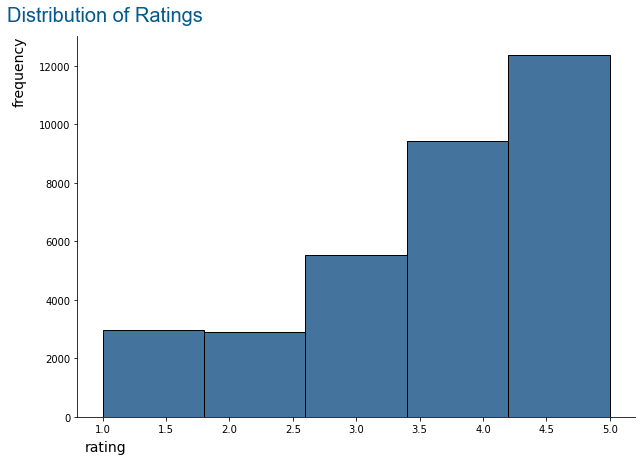

In [19]:
num_bins = 5

font = {'family': 'Arial',
       'color': '#045a8d',
       'size': 20}

fig, ax = plt.subplots(figsize = (10,7))

n, bins, patches = ax.hist(df['rating'], num_bins, facecolor='#44749D', edgecolor='#000000', linewidth=1)

ax.set_title('Distribution of Ratings', fontdict = font, pad=15)
ax.set_xlabel('rating', fontsize = 14)
ax.set_ylabel('frequency', fontsize = 14)

ax.title.set_position([.05, 0])
ax.yaxis.set_label_coords(-.09,.91)
ax.xaxis.set_label_coords(.05, -.06)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

plt.savefig('graphs/histogram_ratings.jpg', format='jpg', dpi=300, bbox_inches='tight')

plt.show()

## Check Text is English

Remove any reviews that is not in the english language.

In [20]:
df.loc[:,'language'] = df.loc[:,'text'].apply(lambda x: str(langid.classify(x)))

In [21]:
df.head(3)

,hotel_city,latitude,longitude,name,hotel_state,date,rating,text,user_city,user_state,language
0,Mableton,45.421611,12.376187,Hotel Russo Palace,GA,2013-09-22 00:00:00+00:00,4.0,Pleasant 10 min walk along the sea front to th...,NaN,NaN,"('en', -390.9012541770935)"
1,Mableton,45.421611,12.376187,Hotel Russo Palace,GA,2015-04-03 00:00:00+00:00,5.0,Really lovely hotel. Stayed on the very top fl...,NaN,NaN,"('en', -535.3024659156799)"
2,Mableton,45.421611,12.376187,Hotel Russo Palace,GA,2014-05-13 00:00:00+00:00,5.0,Ett mycket bra hotell. Det som drog ner betyge...,NaN,NaN,"('sv', -322.44304609298706)"


In [22]:
# filter reviews that are only in the english language
df = df[df['language'].str.contains('en')]
df.head(3)

,hotel_city,latitude,longitude,name,hotel_state,date,rating,text,user_city,user_state,language
0,Mableton,45.421611,12.376187,Hotel Russo Palace,GA,2013-09-22 00:00:00+00:00,4.0,Pleasant 10 min walk along the sea front to th...,NaN,NaN,"('en', -390.9012541770935)"
1,Mableton,45.421611,12.376187,Hotel Russo Palace,GA,2015-04-03 00:00:00+00:00,5.0,Really lovely hotel. Stayed on the very top fl...,NaN,NaN,"('en', -535.3024659156799)"
3,Mableton,45.421611,12.376187,Hotel Russo Palace,GA,2013-10-27 00:00:00+00:00,5.0,We stayed here for four nights in October. The...,NaN,NaN,"('en', -713.2087678909302)"


In [23]:
df = df.reset_index()

In [24]:
df.head(3)

,index,hotel_city,latitude,longitude,name,hotel_state,date,rating,text,user_city,user_state,language
0,0,Mableton,45.421611,12.376187,Hotel Russo Palace,GA,2013-09-22 00:00:00+00:00,4.0,Pleasant 10 min walk along the sea front to th...,NaN,NaN,"('en', -390.9012541770935)"
1,1,Mableton,45.421611,12.376187,Hotel Russo Palace,GA,2015-04-03 00:00:00+00:00,5.0,Really lovely hotel. Stayed on the very top fl...,NaN,NaN,"('en', -535.3024659156799)"
2,3,Mableton,45.421611,12.376187,Hotel Russo Palace,GA,2013-10-27 00:00:00+00:00,5.0,We stayed here for four nights in October. The...,NaN,NaN,"('en', -713.2087678909302)"


## Create Pos/Neg/Neutral Column

negative: 0-2 rating

neutral: 3 rating

postivie: 4-5 rating

In [25]:
# bin the data into negative, neutral, and positive values
bins = [0, 2, 4, 6]

bin_names = ['negative', 'neutral', 'positive']

score_bin = pd.Series(df.rating, name = 'score')

score = pd.cut(score_bin, bins, labels=bin_names, right=False)

In [26]:
# number of counts per score

pd.value_counts(score)

positive    20737
neutral      8084
negative     2849
Name: score, dtype: int64

In [27]:
# add the bins into the dataframe

df = pd.concat([df, score], axis=1)

df.head(2)

,index,hotel_city,latitude,longitude,name,hotel_state,date,rating,text,user_city,user_state,language,score
0,0,Mableton,45.421611,12.376187,Hotel Russo Palace,GA,2013-09-22 00:00:00+00:00,4.0,Pleasant 10 min walk along the sea front to th...,NaN,NaN,"('en', -390.9012541770935)",positive
1,1,Mableton,45.421611,12.376187,Hotel Russo Palace,GA,2015-04-03 00:00:00+00:00,5.0,Really lovely hotel. Stayed on the very top fl...,NaN,NaN,"('en', -535.3024659156799)",positive


## Pos/Neg by Year

In [28]:
# select columns
rate_by_year = df[['score']]

# get year of date
year = df['date'].dt.year

#concat the two togethre
rate_by_year = pd.concat([rate_by_year, year], axis=1)

In [29]:
rate_by_year

,score,date
0,positive,2013.0
1,positive,2015.0
2,positive,2013.0
3,positive,2015.0
4,positive,2014.0
...,...,...
31665,positive,2016.0
31666,positive,2016.0
31667,positive,2012.0
31668,positive,2012.0


In [30]:
# drop the missing values
rate_by_year.dropna(inplace=True)

# change date from float to int
rate_by_year['date'] = rate_by_year['date'].astype('int64')

#group by year and count of score 
grouped = rate_by_year.groupby(['date', 'score']).size()

grouped.head()

date  score   
2002  negative    2
      neutral     2
      positive    9
2003  neutral     1
      positive    4
dtype: int64

In [31]:
# unstack the groupby for plotting
grouped2 = rate_by_year.groupby(['date', 'score']).size().unstack()
grouped2.head()

score,negative,neutral,positive
date,,,
2002,2.0,2.0,9.0
2003,NaN,1.0,4.0
2004,NaN,1.0,4.0
2005,2.0,11.0,10.0
2006,5.0,12.0,30.0


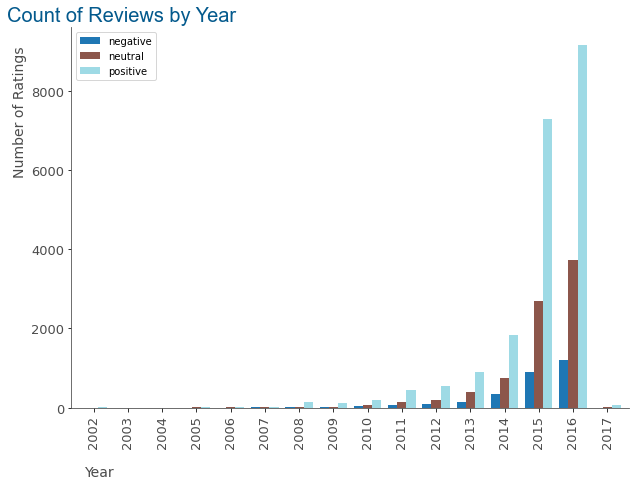

In [32]:
# plot year over year comparison

font = {'family': 'Arial',
       'color': '#045a8d',
       'size': 20}


fig, ax = plt.subplots(figsize=(10,7))



grouped2.plot.bar(ax=ax, width = .8, cmap = 'tab20')

ax.set_title("Count of Reviews by Year", fontdict=font)
ax.set_xlabel('Year', fontsize = 14, color='#4c4c4c')
ax.set_ylabel('Number of Ratings', fontsize = 14, color='#4c4c4c')

# legend and ticks
ax.legend(fontsize=13, ncol=1, loc='upper left', frameon=False)
plt.xticks(fontsize=13, horizontalalignment='center', color='#4c4c4c')
plt.yticks(fontsize=13, color='#4c4c4c')

# set axis label positions
ax.yaxis.set_label_coords(-.08,.78)
ax.xaxis.set_label_coords(.05, -.15)
ax.title.set_position([.09, .8])

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# spine color
ax.spines['left'].set_color('#4c4c4c')
ax.spines['bottom'].set_color('#4c4c4c')

# tick line color
for t in ax.xaxis.get_ticklines(): t.set_color('#4c4c4c')
for t in ax.yaxis.get_ticklines(): t.set_color('#4c4c4c')

ax.legend()

plt.savefig('graphs/reviews_years.jpg', format='jpg', dpi=300, bbox_inches='tight')

plt.show()

## Counts

### Top 10 hotels with most reviews

In [33]:
# number of counts per score

hotels = pd.Series(df['name'])
hotel_counts = pd.value_counts(hotels)

In [34]:
# top 10 hotels with most reviews
hotel_counts.head(10)

The Alexandrian, Autograph Collection           1114
Howard Johnson Inn - Newburgh                    594
Americas Best Value Inn                          541
Fiesta Inn and Suites                            403
Ip Casino Resort Spa                             359
Comfort Suites                                   319
Best Western of Long Beach                       316
Plaza Hotel and Casino - Las Vegas               284
Best Western Plus Waterville Grand Hotel         284
Doubletree By Hilton West Palm Beach Airport     275
Name: name, dtype: int64

### Top 10 states with most reviews

In [35]:
states = pd.Series(df['hotel_state'])
hotel_state = pd.value_counts(states)

In [36]:
# top 10 hotels with most reviews
hotel_state.head(10)

CA    3670
VA    2429
TX    1489
FL    1284
GA    1052
NY    1024
PA     891
MI     883
CO     827
LA     647
Name: hotel_state, dtype: int64

In [37]:
# select top 10 from series
top_10_states = hotel_state[:10,]

# sort values ascending order
top_10_states = top_10_states.sort_values(ascending=True)

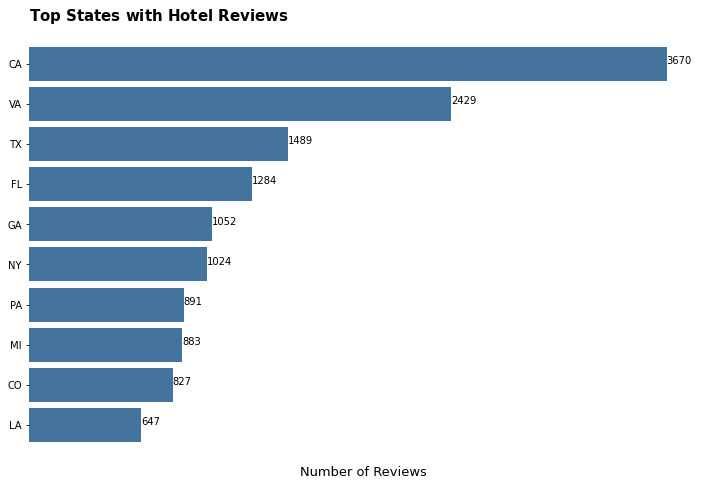

In [38]:
# length of data
y_pos = np.arange(len(top_10_states))

# create figure
fig, ax = plt.subplots(figsize = (12,8))

# width of the bar
width = .85

# create horizontal bar chart
rects = ax.barh(y_pos, top_10_states.values, width,
        align = 'center',
       tick_label = top_10_states.index,
                color = "#44749D"
       )

# remove x axis ticks
ax.axes.xaxis.set_ticks([])

# remove vertical grid
ax.xaxis.grid(False)

# remove horizontal grid
ax.yaxis.grid(False)

# set x axis label
ax.set_xlabel('Number of Reviews', fontsize = 13)

# title
ax.set_title('$\\bf{Top\ States\ with\ Hotel\ Reviews}$', fontsize = 15, loc = 'left')

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


# add total numbers to edge
for i, v in enumerate(top_10_states.values):
    plt.text(v, i, str(v))

plt.savefig('graphs/top_states.jpg', format='jpg', dpi=300, bbox_inches='tight')

plt.show()

## Word Counts

In [39]:
counts_df = df[['score', 'text']]

In [40]:
# number of words in the review
counts_df.loc[:,'word_count'] = counts_df.loc[:,'text'].apply(lambda x: len(str(x).split(" ")))

In [41]:
# number of characters in the review
counts_df.loc[:,'char_count'] = counts_df.loc[:,'text'].str.len()

In [42]:
counts_df.head()

,score,text,word_count,char_count
0,positive,Pleasant 10 min walk along the sea front to th...,33,194
1,positive,Really lovely hotel. Stayed on the very top fl...,44,252
2,positive,We stayed here for four nights in October. The...,59,354
3,positive,We loved staying on the island of Lido! You ne...,62,326
4,positive,Lovely view out onto the lagoon. Excellent vie...,13,82


The max word count is 717 words and the min word count is 1 word. The average word count is 48 characters.

The max character count is 3,772 characters, the min character count is 1 character. The average character count is 261 characters.

In [43]:
counts_df.describe()

,word_count,char_count
count,31670.000000,31670.000000
mean,47.974613,261.082286
std,40.883577,217.354330
min,1.000000,1.000000
25%,19.000000,109.000000
50%,43.000000,234.000000
75%,61.000000,332.000000
max,717.000000,3772.000000


In [44]:
# separate by positive and negative reviews
counts_pos = counts_df.loc[(counts_df['score']=='positive')]

counts_neg = counts_df.loc[(counts_df['score']=='negative')]

The average positive review is 43 words long.

The average negative review is 64 words long.

In [45]:
counts_pos.describe()

,word_count,char_count
count,20737.000000,20737.000000
mean,43.379081,238.985919
std,34.689683,187.626009
min,1.000000,1.000000
25%,18.000000,101.000000
50%,40.000000,222.000000
75%,61.000000,325.000000
max,614.000000,3296.000000


In [46]:
counts_neg.describe()

,word_count,char_count
count,2849.000000,2849.000000
mean,64.001053,338.918568
std,55.269396,287.234435
min,1.000000,3.000000
25%,28.000000,148.000000
50%,56.000000,293.000000
75%,73.000000,389.000000
max,398.000000,1998.000000


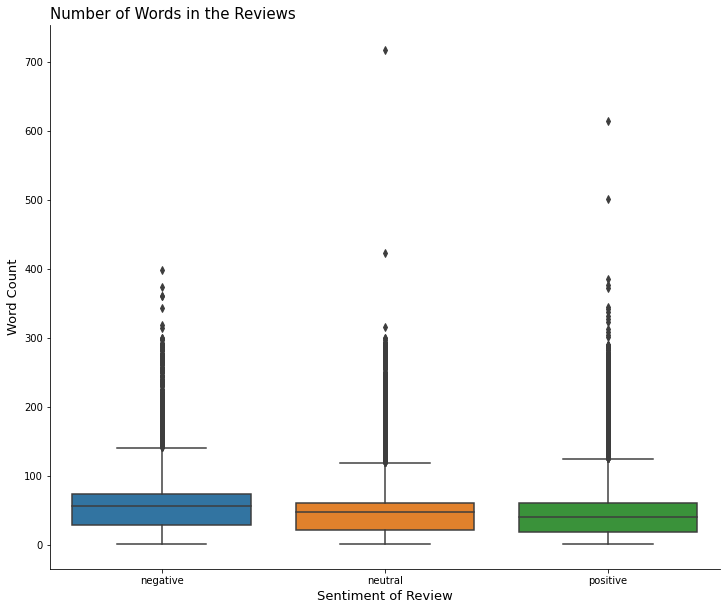

In [47]:
# create figure
fig, ax = plt.subplots(figsize = (12,10))

sns.boxplot(x=counts_df['score'], y=counts_df['word_count'])

# title
ax.set_title('Number of Words in the Reviews', fontsize = 15, loc = 'left')

# set x axis label
ax.set_xlabel('Sentiment of Review', fontsize = 13)

# set y axis label
ax.set_ylabel('Word Count', fontsize = 13)

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

plt.show()

## Final shape

In [48]:
print('There are {} total number of reviews to find insights from.'.format(df.shape[0]))

There are 31670 total number of reviews to find insights from.


## Export cleaned df

In [49]:
# export cleaned df
df.to_csv('data/hotel_reviews.csv', index=False)